Pairs trading results:
                          pair  total_return  sharpe_ratio  max_drawdown
0      (RELIANCE.NS, CIPLA.NS)    246.409929      4.356539     -0.296501
1    (RELIANCE.NS, SBILIFE.NS)    151.845697      1.635201     -4.334705
2        (TCS.NS, HDFCBANK.NS)    606.824122      5.916828     -0.484319
3      (TCS.NS, BAJFINANCE.NS)    956.215319      6.140940     -1.688054
4      (TCS.NS, ASIANPAINT.NS)    735.852436      3.716970     -1.129236
..                         ...           ...           ...           ...
96      (BPCL.NS, SHREECEM.NS)     74.905635      5.285383     -0.349368
97      (M&M.NS, EICHERMOT.NS)    198.948622      2.020048     -8.497971
98    (CIPLA.NS, EICHERMOT.NS)    169.831459      3.206165     -0.902633
99      (CIPLA.NS, SBILIFE.NS)    164.534991      3.305449    -13.325426
100  (CIPLA.NS, TATAMOTORS.NS)    -13.767303     -1.040313     -1.216198

[101 rows x 4 columns]

Best performing pair: ('KOTAKBANK.NS', 'BAJFINANCE.NS')


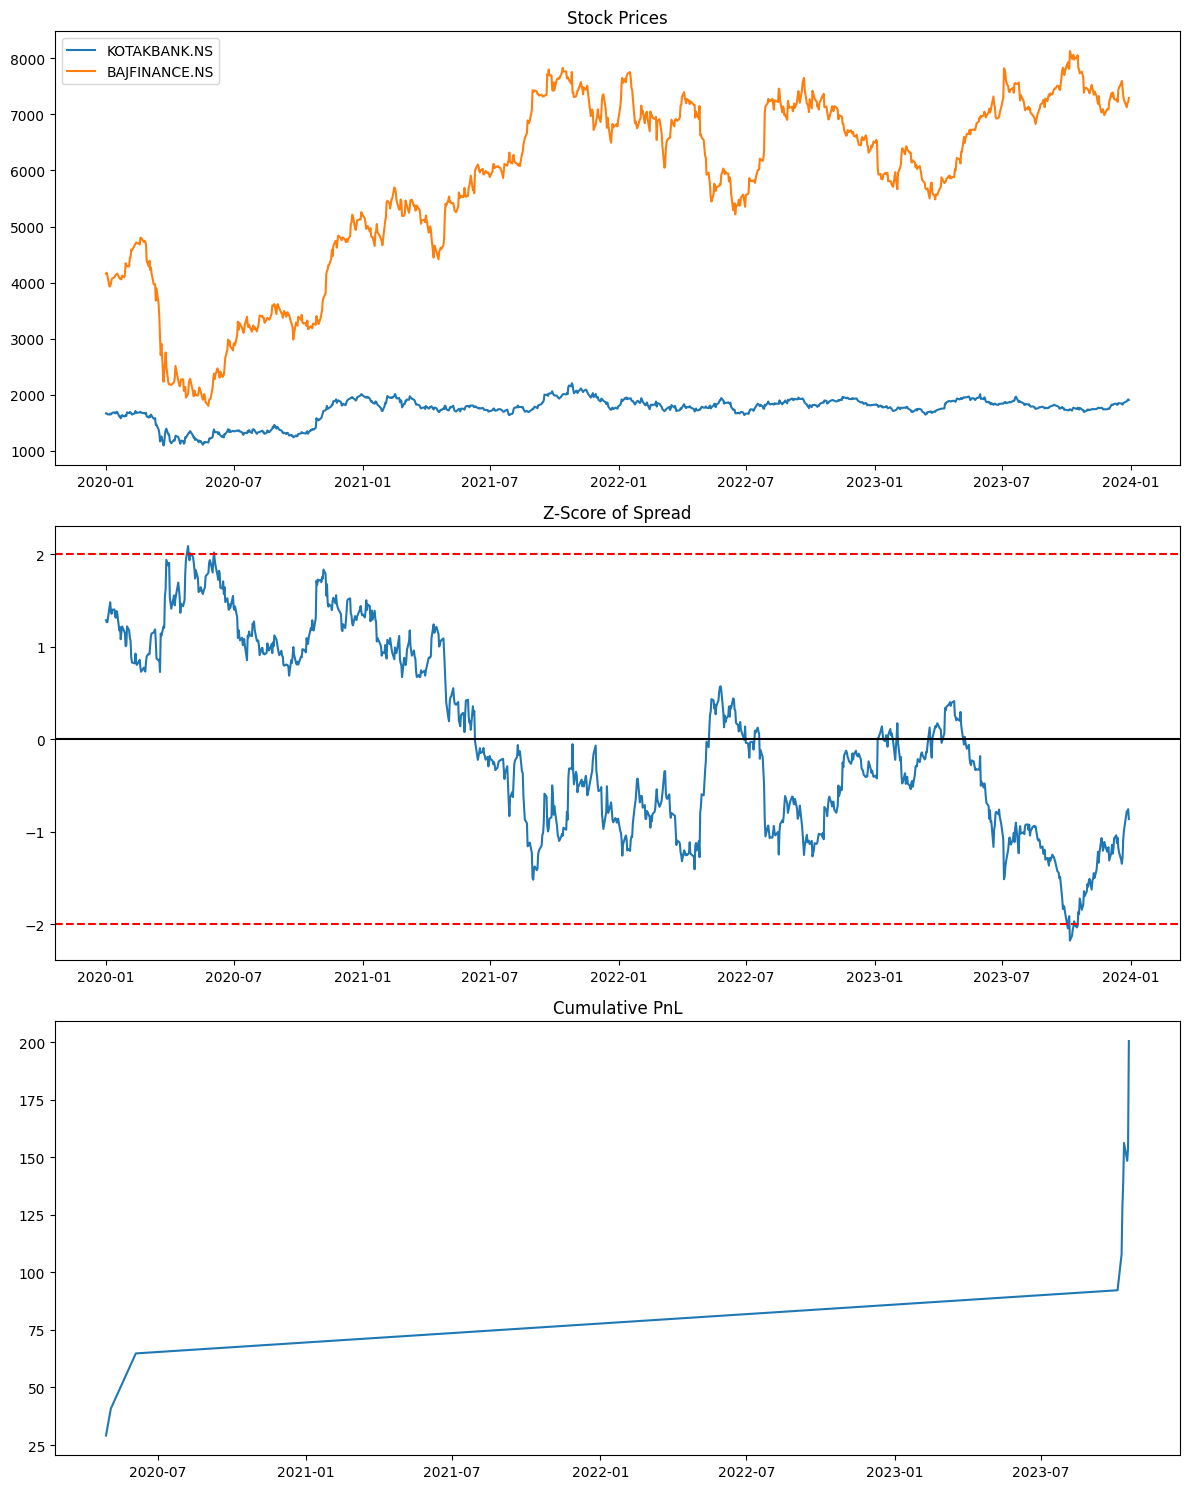

Cointegrated pairs saved to cointegrated_pairs.csv


In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint, adfuller
from statsmodels.regression.linear_model import OLS
import yfinance as yf
from itertools import combinations
import seaborn as sns

class PairsTrader:
    def __init__(self, symbols, start_date, end_date):
        self.symbols = symbols
        self.start_date = start_date
        self.end_date = end_date
        self.data = None
        
    def fetch_data(self):
        data = {}
        for symbol in self.symbols:
            stock = yf.Ticker(symbol)
            data[symbol] = stock.history(start=self.start_date, end=self.end_date)['Close']
        self.data = pd.DataFrame(data)
        self.data.dropna(inplace=True)
        
    def test_all_pairs(self):
        results = []
        for symbol1, symbol2 in combinations(self.symbols, 2):
            pair_trader = SinglePairTrader(symbol1, symbol2, self.data[symbol1], self.data[symbol2])
            if pair_trader.test_cointegration():
                pair_trader.calculate_spread()
                pair_trader.backtest()
                pair_trader.calculate_metrics()
                results.append({
                    'pair': (symbol1, symbol2),
                    'total_return': pair_trader.total_return,
                    'sharpe_ratio': pair_trader.sharpe_ratio,
                    'max_drawdown': pair_trader.max_drawdown
                })
        return pd.DataFrame(results)
    
    def save_cointegrated_pairs(self, output_file="cointegrated_pairs.csv"):
        pairs_data = []
        for symbol1, symbol2 in combinations(self.symbols, 2):
            data1 = self.data[symbol1]
            data2 = self.data[symbol2]
            _, pvalue, _ = coint(data1, data2)
            if pvalue < 0.05:
                model = OLS(data1, data2)
                results = model.fit()
                beta = results.params[0]
                pairs_data.append({
                    "Pair": f"{symbol1}-{symbol2}",
                    "P-Value": pvalue,
                    "Beta": beta
                })

        pairs_df = pd.DataFrame(pairs_data)
        pairs_df.to_csv(output_file, index=False)
        print(f"Cointegrated pairs saved to {output_file}")
    
    def plot_best_pair(self, best_pair):
        symbol1, symbol2 = best_pair
        pair_trader = SinglePairTrader(symbol1, symbol2, self.data[symbol1], self.data[symbol2])
        pair_trader.calculate_spread()
        pair_trader.backtest()
        pair_trader.plot_results()

class SinglePairTrader:
    def __init__(self, symbol1, symbol2, data1, data2):
        self.symbol1 = symbol1
        self.symbol2 = symbol2
        self.data = pd.DataFrame({symbol1: data1, symbol2: data2})
        self.beta = None
        self.spread = None
        self.z_score = None
        self.positions = None
        self.pnl = None
        self.total_return = None
        self.sharpe_ratio = None
        self.max_drawdown = None
        
    def test_cointegration(self):
        _, pvalue, _ = coint(self.data[self.symbol1], self.data[self.symbol2])
        return pvalue < 0.05
    
    def calculate_spread(self):
        model = OLS(self.data[self.symbol1], self.data[self.symbol2])
        results = model.fit()
        self.beta = results.params[0]
        self.spread = self.data[self.symbol1] - self.beta * self.data[self.symbol2]
        self.z_score = (self.spread - self.spread.mean()) / self.spread.std()
        
    def generate_signals(self, entry_threshold=2, exit_threshold=0):
        signals = pd.DataFrame(index=self.data.index)
        signals['signal'] = 0
        signals.loc[self.z_score > entry_threshold, 'signal'] = -1
        signals.loc[self.z_score < -entry_threshold, 'signal'] = 1
        signals.loc[abs(self.z_score) < exit_threshold, 'signal'] = 0
        return signals
    
    def backtest(self, entry_threshold=2, exit_threshold=0):
        signals = self.generate_signals(entry_threshold, exit_threshold)
        self.positions = signals.shift(1)
        self.pnl = self.positions['signal'] * self.spread.diff()
        self.pnl = self.pnl[self.pnl != 0]  # Remove days with no trades
        
    def calculate_metrics(self):
        self.total_return = self.pnl.sum()
        self.sharpe_ratio = np.sqrt(252) * self.pnl.mean() / self.pnl.std()
        self.max_drawdown = ((self.pnl.cumsum() - self.pnl.cumsum().cummax())/self.pnl.cumsum().cummax()).min()
        
    def plot_results(self):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 15))
        ax1.plot(self.data)
        ax1.set_title('Stock Prices')
        ax1.legend([self.symbol1, self.symbol2])
        ax2.plot(self.z_score)
        ax2.axhline(y=2, color='r', linestyle='--')
        ax2.axhline(y=-2, color='r', linestyle='--')
        ax2.axhline(y=0, color='k', linestyle='-')
        ax2.set_title('Z-Score of Spread')
        ax3.plot(self.pnl.cumsum())
        ax3.set_title('Cumulative PnL')
        plt.tight_layout()
        plt.show()


# Example usage with 50 different stocks of the NSE index

symbols = ['RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'HINDUNILVR.NS', 'ICICIBANK.NS', 'KOTAKBANK.NS', 'SBIN.NS', 'BAJFINANCE.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'ITC.NS', 'HCLTECH.NS', 'LT.NS', 'AXISBANK.NS', 'MARUTI.NS', 'HDFCLIFE.NS', 'SUNPHARMA.NS', 'WIPRO.NS', 'ULTRACEMCO.NS', 'NESTLEIND.NS', 'TITAN.NS', 'BAJAJFINSV.NS', 'DRREDDY.NS', 'DIVISLAB.NS', 'ADANIGREEN.NS', 'ADANIPORTS.NS', 'ADANIENT.NS', 'GRASIM.NS', 'JSWSTEEL.NS', 'TATASTEEL.NS', 'TECHM.NS', 'HINDALCO.NS', 'ONGC.NS', 'COALINDIA.NS', 'BPCL.NS', 'IOC.NS', 'POWERGRID.NS', 'NTPC.NS', 'HEROMOTOCO.NS', 'M&M.NS', 'BRITANNIA.NS', 'SHREECEM.NS', 'CIPLA.NS', 'BAJAJ-AUTO.NS', 'EICHERMOT.NS', 'SBILIFE.NS', 'TATAMOTORS.NS', 'VEDL.NS', 'GAIL.NS']

trader = PairsTrader(symbols, '2020-01-01', '2023-12-31')
trader.fetch_data()
results = trader.test_all_pairs()


print("Pairs trading results:")
print(results)

# Find the best performing pair based on Sharpe ratio
best_pair = tuple(results.loc[results['sharpe_ratio'].idxmax(), 'pair'])
print(f"\nBest performing pair: {best_pair}")

# Plot results for the best pair
trader.plot_best_pair(best_pair)

# Save cointegrated pairs to a file
trader.save_cointegrated_pairs("cointegrated_pairs.csv")

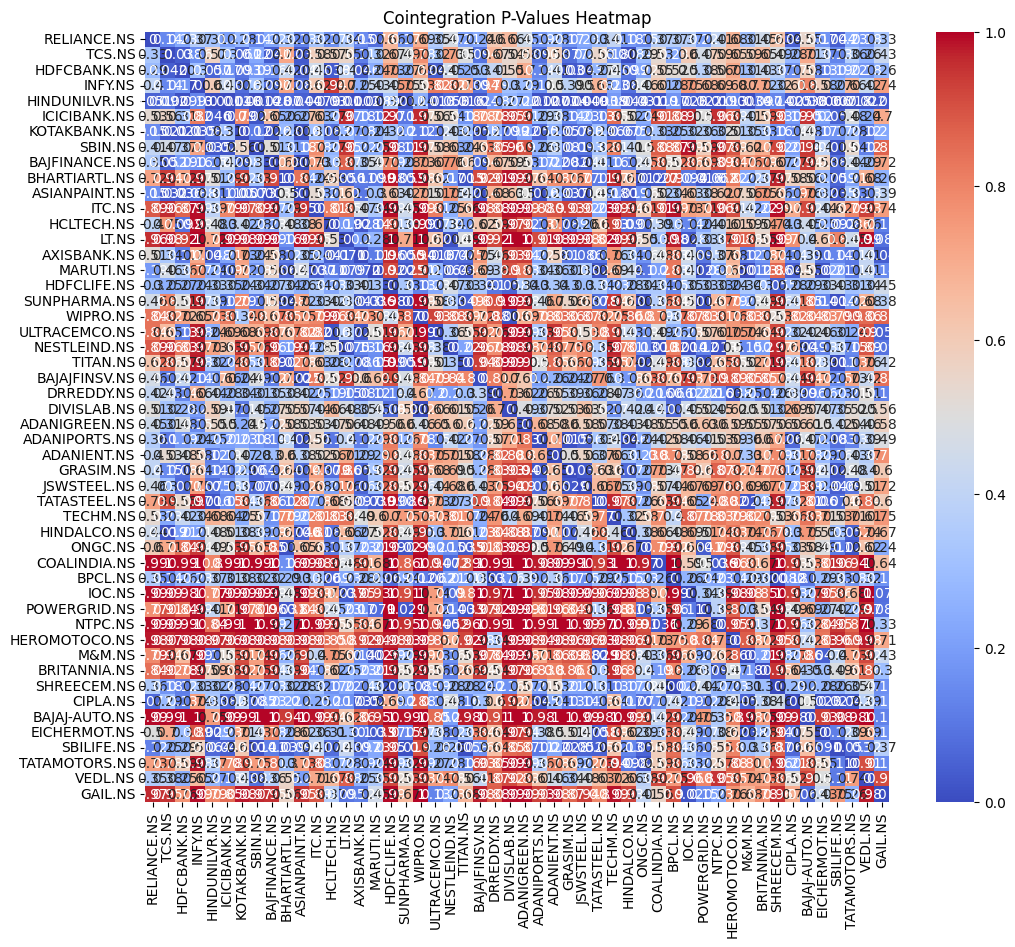

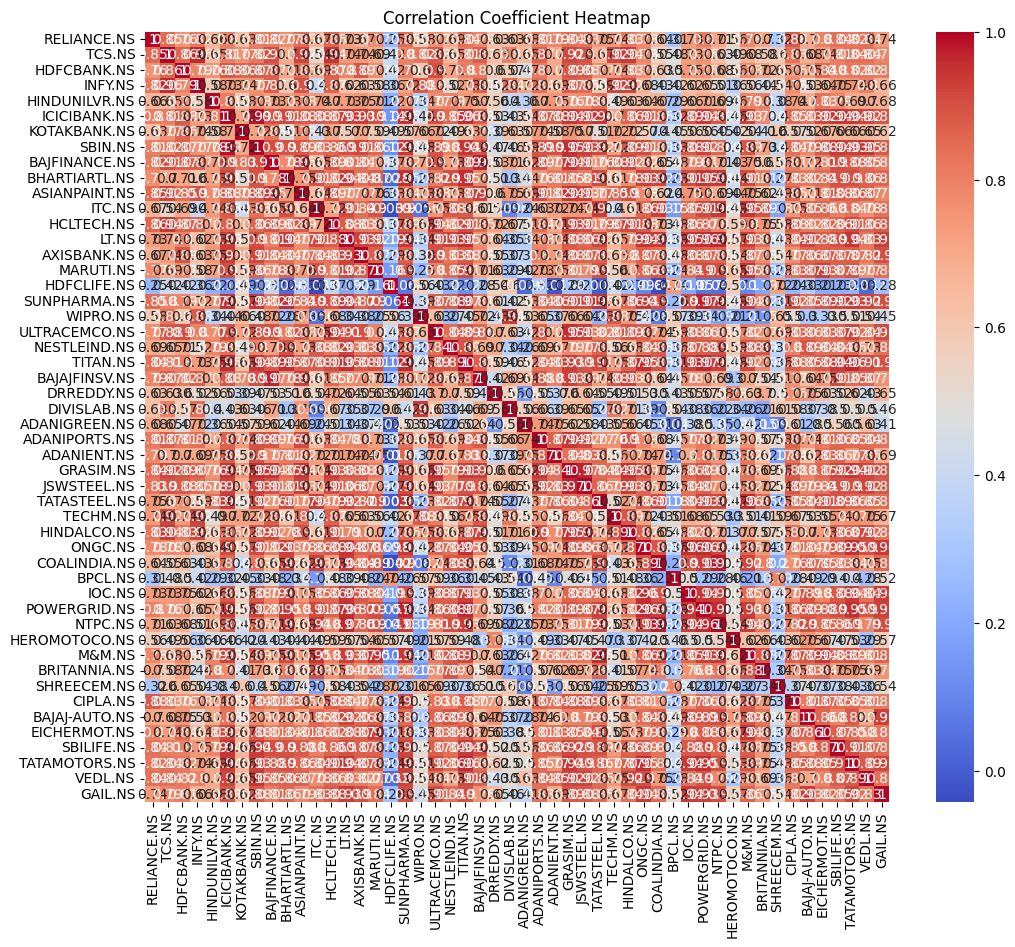

In [12]:
class HeatmapGenerator:
    def __init__(self, symbols, data):
        self.symbols = symbols
        self.data = data

    def generate_cointegration_heatmap(self, save_as_file=False):
        matrix_size = len(self.symbols)
        pvalues = np.zeros((matrix_size, matrix_size))

        for i, symbol1 in enumerate(self.symbols):
            for j, symbol2 in enumerate(self.symbols):
                if i != j:
                    _, pvalue, _ = coint(self.data[symbol1], self.data[symbol2])
                    pvalues[i, j] = pvalue

        plt.figure(figsize=(12, 10))
        sns.heatmap(pvalues, xticklabels=self.symbols, yticklabels=self.symbols, annot=True, cmap='coolwarm')
        plt.title('Cointegration P-Values Heatmap')
        plt.show()
        if save_as_file:
            with pd.ExcelWriter("cointegration_matrix.xlsx") as writer:
                pvalues_df = pd.DataFrame(pvalues, index=self.symbols, columns=self.symbols)
                pvalues_df.to_excel(writer, sheet_name='Cointegration P-Values')

    def generate_correlation_heatmap(self, save_as_file=False):
        correlation_matrix = self.data.corr()
        plt.figure(figsize=(12, 10))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=self.symbols, yticklabels=self.symbols)
        plt.title('Correlation Coefficient Heatmap')
        plt.show()
        if save_as_file:
            with pd.ExcelWriter("correlation_matrix.xlsx") as writer:
                correlation_matrix.to_excel(writer, sheet_name='Correlation Coefficients')

    def save_heatmaps_to_excel(self, filename="heatmaps.xlsx"):
        with pd.ExcelWriter(filename) as writer:
            # Cointegration heatmap
            matrix_size = len(self.symbols)
            pvalues = np.zeros((matrix_size, matrix_size))

            for i, symbol1 in enumerate(self.symbols):
                for j, symbol2 in enumerate(self.symbols):
                    if i != j:
                        _, pvalue, _ = coint(self.data[symbol1], self.data[symbol2])
                        pvalues[i, j] = pvalue

            pvalues_df = pd.DataFrame(pvalues, index=self.symbols, columns=self.symbols)
            pvalues_df.to_excel(writer, sheet_name='Cointegration P-Values')

            # Correlation heatmap
            correlation_matrix = self.data.corr()
            correlation_matrix.to_excel(writer, sheet_name='Correlation Coefficients')

        print(f"Heatmaps saved to {filename}")


heatmap_generator = HeatmapGenerator(symbols, trader.data)

heatmap_generator.generate_cointegration_heatmap(save_as_file=True)
heatmap_generator.generate_correlation_heatmap(save_as_file=True)
# heatmap_generator.save_heatmaps_to_excel("heatmaps.xlsx")